In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse.csgraph import reverse_cuthill_mckee

import matplotlib
from matplotlib import pyplot as plt
#plt.style.use('dark_background')

In [2]:
class Mesh:
    def __init__(self):
        self.nodes_dict = {}   # Nodes dict <---> ID: [x y z]
        self.elems_dict = {}   # Elems dict <---> ID: [ne_1, ne_2, ...]
        self.N_nodes = 0
        self.N_elems = 0
        
    def read_mesh(self, mesh_name):
        # Reading nodes
        nodes_file = open(mesh_name + '_nodes.txt', 'r')
        
        for line in nodes_file:
            data_tokens = list(map(float, line.split(' ')))
            node_ID = int(data_tokens[0])
            coord_array = data_tokens[1:]
            self.nodes_dict[node_ID] = coord_array
            
        self.N_nodes = len(self.nodes_dict.keys())
        nodes_file.close()
        
        # Reading elems
        elems_file = open(mesh_name + '_elems.txt', 'r')
        
        for line in elems_file:
            if (line == ''):
                break
            data_tokens = list(map(int, line.replace(' \n', '').split(' ')))
            elem_ID = data_tokens[0]
            elem_nodes = data_tokens[1:]
            self.elems_dict[elem_ID] = elem_nodes
            
        self.N_elems = len(self.elems_dict.keys())
        elems_file.close()
        
        print(f'Mesh from [{mesh_name}] loaded.\n')
        print(f'Nodes: \t\t{self.N_nodes}')
        print(f'Elements: \t{self.N_elems}')
        
        self.mesh_borders()
    
    def get_mesh(self):
        return self.nodes_dict, self.elems_dict
    
    def mesh_borders(self):
        self.min_x = 1e9
        self.max_x = -1e9
        self.min_y = 1e9
        self.max_y = -1e9
        
        for node_id in list(self.nodes_dict.keys()):
            node_x, node_y, node_z = tuple(self.nodes_dict[node_id])
            if (node_x > self.max_x):
                self.max_x = node_x
            if (node_x < self.min_x):
                self.min_x = node_x
            if (node_y > self.max_y):
                self.max_y = node_y
            if (node_y < self.min_y):
                self.min_y = node_y
                
    def left_bottom(self):
        for node_id in list(self.nodes_dict.keys()):
            node_x, node_y, node_z = tuple(self.nodes_dict[node_id])
            if (node_x == self.min_x and node_y == self.min_y):
                return node_id
                
    def left_upper(self):
        for node_id in list(self.nodes_dict.keys()):
            node_x, node_y, node_z = tuple(self.nodes_dict[node_id])
            if (node_x == self.min_x and node_y == self.max_y):
                return node_id
                
    def right_bottom(self):
        for node_id in list(self.nodes_dict.keys()):
            node_x, node_y, node_z = tuple(self.nodes_dict[node_id])
            if (node_x == self.max_x and node_y == self.min_y):
                return node_id

In [3]:
class FEM:
    def __init__(self, nodes_dict, elems_dict, nu, E):
        self.nodes_dict = nodes_dict                    # Nodes dict <---> ID: [x y z]
        self.elems_dict = elems_dict                    # Elems dict <---> ID: [ne_1, ne_2, ...]
        self.B_matricies = {}
        self.elems_strains = {}
        self.elems_stresses = {}
        
        self.N_nodes = len(nodes_dict.keys())
        self.N_elems = len(elems_dict.keys())
        
        self.N_dofs = self.N_nodes * 2                  # 2D case, DOFs along X and Y
        self.dofs_mapping = {}                          # Degrees of freedom for each element
        
        self.nu = nu
        self.E = E
        
        self.local_K = np.ones((6,6))                  
        self.global_K = None                            # Global stiffness matrix K
        
        self.D = E * np.array([
            [1-nu, nu, 0],
            [nu, 1-nu, 0],
            [0, 0, 0.5*(1-2*nu)]
        ]) / ((1 + nu)*(1 - 2*nu))                      # Hook's Law in matrix form
        
        self.F = np.zeros(self.N_dofs)                  # Nodal forces
        self.U = np.zeros(self.N_dofs)                  # Displacements
        self.fixed_dofs = []                            # Fixed nodes
        self.all_dofs = np.arange(self.N_dofs)
        
    # For each element, calculates its nodes DOFs    
    def map_dofs(self):
        for elem in list(self.elems_dict.keys()):
            nodes = self.elems_dict[elem]
            dofs = []
            for node in nodes:
                dofs.append(2*(node-1))       # DOF along X
                dofs.append(2*(node-1) + 1)   # DOF along Y
            self.dofs_mapping[elem] = dofs
            
    def elem_area(self, elem_ID):
        node_1, node_2, node_3 = tuple(self.elems_dict[elem_ID])
        
        x1 = self.nodes_dict[node_1][0]
        x2 = self.nodes_dict[node_2][0]
        x3 = self.nodes_dict[node_3][0]
        
        y1 = self.nodes_dict[node_1][1]
        y2 = self.nodes_dict[node_2][1]
        y3 = self.nodes_dict[node_3][1]
        
        area = 0.5 * ( (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1) )

        return area
    
    # For triangular mesh?
    def assemble_stiffness_matrix(self):
        global_iK = np.zeros(36 * self.N_elems)
        global_jK = np.zeros(36 * self.N_elems)
        global_aK = np.zeros(36 * self.N_elems)
        
        for ei, elem in enumerate(list(self.elems_dict.keys())):
            iK = np.kron(self.dofs_mapping[elem], np.ones(6))
            jK = np.reshape(np.kron(self.dofs_mapping[elem], np.reshape(np.ones(6), (6,1))), -1)
            aK = np.reshape(self.local_stiffness_matrix(elem), -1)
            
            global_iK[36*ei : 36*(ei+1)] = iK
            global_jK[36*ei : 36*(ei+1)] = jK
            global_aK[36*ei : 36*(ei+1)] = aK
            
        self.global_K = sparse.coo_matrix((global_aK,(global_iK, global_jK)),shape = (self.N_dofs, self.N_dofs)).tocsr()
        
    def local_stiffness_matrix(self, elem_ID):
        elem_nodes_IDs = self.elems_dict[elem_ID]
        elem_nodes_coords = [self.nodes_dict[node_id] for node_id in elem_nodes_IDs]
        
        x1 = elem_nodes_coords[0][0]
        x2 = elem_nodes_coords[1][0]
        x3 = elem_nodes_coords[2][0]
        
        y1 = elem_nodes_coords[0][1]
        y2 = elem_nodes_coords[1][1]
        y3 = elem_nodes_coords[2][1]

        area = self.elem_area(elem_ID)
    
        B = np.array([
            [y2 - y3, 0, y3 - y1, 0, y1 - y2, 0],
            [0, x3 - x2, 0, x1 - x3, 0, x2 - x1],
            [x3 - x2, y2 - y3, x1 - x3, y3 - y1, x2 - x1, y1 - y2],
        ]) / (2*area)
        
        self.B_matricies[elem_ID] = B
        
        local_stiffness_matrix = B.transpose().dot(self.D).dot(B) * area * 2
        
        return local_stiffness_matrix
    
    def solve_U(self):
        free_dofs = np.setdiff1d(self.all_dofs, self.fixed_dofs)
        self.U[free_dofs] = spsolve(self.global_K[free_dofs, :][:, free_dofs], self.F[free_dofs])
        
        return self.U
        
    def apply_load(self, node_ID, force_X, force_Y):
        dof_x = 2*(node_ID-1)  
        dof_y = 2*(node_ID-1) + 1
        self.F[dof_x] = force_X
        self.F[dof_y] = force_Y
        
    def fix_node(self, node_ID, fix_X, fix_Y):
        dof_x = 2*(node_ID-1)
        dof_y = 2*(node_ID-1) + 1
        if (fix_X == True):
            self.fixed_dofs.append(dof_x)
        if (fix_Y == True):
            self.fixed_dofs.append(dof_y)
        
    def build_incidence_matrix(self):
        self.incidence_matrix = np.zeros((self.N_nodes, self.N_nodes))
        
        # Calculating incidence from elements
        for elem_ID in list(self.elems_dict.keys()):
            nodes = self.elems_dict[elem_ID]
            for i in range(len(nodes)):
                self.incidence_matrix[nodes[i]-1][nodes[i-1]-1] = 1                # Marking LEFT neighbor
                self.incidence_matrix[nodes[i]-1][nodes[(i+1)%len(nodes)]-1] = 1   # Marking RIGHT neighbor
                self.incidence_matrix[nodes[i]-1][nodes[i]-1] = 1                  # Marking node itself
                
    def renumbering(self):
        graph = sparse.csr_matrix(self.incidence_matrix)                     # Creating input graph in scipy sparse matrix form
        permutation = reverse_cuthill_mckee(graph, symmetric_mode = True)    # Incidence matrix is guaranteed to be symmetric
        
        # Updating incidence matrix
        self.incidence_matrix = self.incidence_matrix[permutation, :][:, permutation]
        self.renum_perm = permutation
        
    def revert_renumbering(self):
        inverse_perm = np.argsort(self.renum_perm)
        
        self.incidence_matrix = self.incidence_matrix[inverse_perm, :][:, inverse_perm]
                
    def draw_incidence_matrix(self):
        plt.figure(figsize=(9, 9))
        plt.imshow(self.incidence_matrix, cmap = 'turbo', interpolation = 'none')
        
    def draw_stiffness_matrix(self):
        if (self.N_dofs > 3000):
            print("Too much DOFs: cannot visualize stiffness matrix")
            return
        
        plt.figure(figsize=(7, 7))
        np_represent = self.global_K.toarray()
        for i in range(np_represent.shape[0]):
            for j in range(np_represent.shape[0]):
                if (np_represent[i][j] != 0):
                    np_represent[i][j] = 1.0
                    
        plt.imshow(np_represent, cmap = 'turbo')
        
    def save_results(self, save_path):
        output_file = open(save_path, 'w')
        
        # Saving nodes
        output_file.write(f'{self.N_nodes}\n')
        for node_i in range(1, self.N_nodes + 1):
            dof_x = 2*(node_i - 1)
            dof_y = 2*(node_i - 1) + 1
            u_x = self.U[dof_x]
            u_y = self.U[dof_y]
            node_x, node_y, node_z = tuple(self.nodes_dict[node_i])
            write_str = f'{node_i} {u_x} {u_y} {node_x} {node_y} {node_z}'
            output_file.write(write_str + '\n')
            
        # Saving elements
        output_file.write(f'{self.N_elems}\n')
        for elem_i in list(self.elems_dict.keys()):
            elem_nodes_str = ' '.join(list(map(str, self.elems_dict[elem_i])))
            write_str = f'{elem_i} {elem_nodes_str} {self.elems_stresses[elem_i][1]} {self.elems_strains[elem_i][0]}'
            output_file.write(write_str + '\n')
            
        output_file.close()
        
    def calc_strains(self):
        for elem_ID in list(self.elems_dict.keys()):
            self.elems_strains[elem_ID] = np.dot(self.B_matricies[elem_ID], self.U[self.dofs_mapping[elem_ID]])
            
    def calc_stresses(self):
        for elem_ID in list(self.elems_dict.keys()):
            self.elems_stresses[elem_ID] = np.dot(self.D, self.elems_strains[elem_ID])

    # Mode = 'XX' or 'YY' or 'XY'
    def visualize(self, cmap_, mode, edges, figsize):
        Xs = []
        Ys = []
        Tris = []
        for node_id in list(self.nodes_dict.keys()):
            Xs.append(self.nodes_dict[node_id][0])
            Ys.append(self.nodes_dict[node_id][1])
            
        stresses_xx = []
        stresses_yy = []
        stresses_xy = []
        
        for elem_id in list(self.elems_dict.keys()):
            Tris.append(list(map(lambda x: x-1, self.elems_dict[elem_id])))
            stresses_xx.append(self.elems_stresses[elem_id][0])
            stresses_yy.append(self.elems_stresses[elem_id][1])
            stresses_xy.append(self.elems_stresses[elem_id][2])

        Tris = np.array(Tris)
        mesh = matplotlib.tri.Triangulation(Xs, Ys, Tris)

        fig, axes = plt.subplots(figsize = figsize)

        if (mode == 'XX'):
            axes.set_title('sigma XX')
            pos = axes.tripcolor(mesh, stresses_xx, cmap = cmap_, edgecolors = edges)
            cbar = fig.colorbar(pos, ax = axes, shrink = 0.6)
            cbar.minorticks_on()

        if (mode == 'XY'):
            axes.set_title('sigma XY')
            pos = axes.tripcolor(mesh, stresses_xy, cmap = cmap_, edgecolors = edges)
            cbar = fig.colorbar(pos, ax = axes, shrink = 0.6)
            cbar.minorticks_on()

        if (mode == 'YY'):
            axes.set_title('sigma YY')
            print(f'Max sigma_YY: {max(stresses_yy):.4f}')
            pos = axes.tripcolor(mesh, stresses_yy, cmap = cmap_, edgecolors = edges)
            cbar = fig.colorbar(pos, ax = axes, shrink = 0.6)
            cbar.minorticks_on()

In [4]:
mesh = Mesh()
mesh.read_mesh('Mesh_1')

mesh_nodes, mesh_elems = mesh.get_mesh()

Mesh from [Mesh_1] loaded.

Nodes: 		3739
Elements: 	7198


In [5]:
f_matr = FEM(mesh_nodes, mesh_elems, 0.3, 100)
f_matr.build_incidence_matrix()

In [6]:
f_matr.map_dofs()
f_matr.assemble_stiffness_matrix()

In [7]:
f_matr.elem_area(1000)

6.471837830651955e-05

In [16]:
def kirsh_bounds(mesh):
    node_IDs_upper = []
    node_IDs_bottom = []
    node_IDs_left = []
    node_IDs_right = []
    
    for node_id in list(mesh.nodes_dict.keys()):
        node_y = mesh.nodes_dict[node_id][1]
        node_x = mesh.nodes_dict[node_id][0]
        if (node_y == mesh.max_y):
            node_IDs_upper.append(node_id)
        if (node_y == mesh.min_y):
            node_IDs_bottom.append(node_id)
        if (node_x == mesh.min_x):
            node_IDs_left.append(node_id)
        if (node_x == mesh.max_x):
            node_IDs_right.append(node_id)
            
    return node_IDs_upper, node_IDs_bottom, node_IDs_left, node_IDs_right

In [17]:
upper, bottom, left, right = kirsh_bounds(mesh)

In [18]:
abs_force = 10

# Applying loads
for node in upper:
    if (node in right) or (node in left):
        f_matr.apply_load(node, 0, abs_force/2)
    else:
        f_matr.apply_load(node, 0, abs_force)
    
for node in bottom:
    if node not in right:
        f_matr.fix_node(node, False, True)

for node in left:
    if node not in upper:
        f_matr.fix_node(node, True, False)

for node in right:
    if (node in upper) or (node in bottom):
        f_matr.apply_load(node, abs_force/3, 0)
    else:
        f_matr.apply_load(node, abs_force, 0)

print(f'Side points: {len(right)}')

Side points: 41


In [20]:
# Displacements
U = f_matr.solve_U()

# Strains and stresses
f_matr.calc_strains()
f_matr.calc_stresses()

Max sigma_YY: 1556.6227


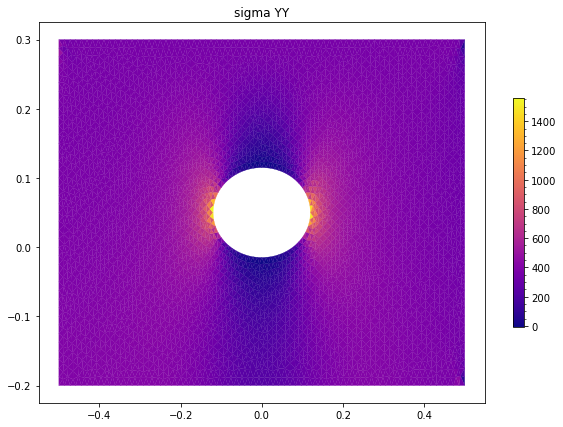

In [23]:
f_matr.visualize(cmap_ = 'plasma', mode = 'YY', edges = 'face', figsize = (10, 7))